# Import Modules

In [158]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import dabest

print("We're using DABEST v{}".format(dabest.__version__))

We're using DABEST v0.2.4


In [2]:
pwd

'/Users/michaelpiacentino/Drive/git/data/nSMase2/MigrationArea'

# Assemble data into a dataframe

In [3]:
# Add analysis date here to apply to dataframe
analysis_date = '20190612'

path = os.path.abspath('')+'/CSVs/'
full_df = pd.DataFrame()
list_ = []

# For loop to bring in files and concatenate them into a single dataframe
for file_ in glob.glob(path + "/*.csv"):
    df = pd.read_csv(file_)
    # Determine Image name from file name
    df['Image'] = os.path.splitext(os.path.basename(file_))[0]
    # Split values in ROI label and Image name columns
    df['delete1'], df['ROI'], df['delete2'], df['delete3'] = zip(*df['Label'].map(lambda x: x.split(':')))
    (df['ExptDate'], df['Treatment'], df['Dose'], df['Stains'], df['Embryo'], 
        df['Somites'], df['ImageMag']) = zip(*df['Image'].map(lambda x: x.split('_')))
    list_.append(df)

full_df = pd.concat(list_)
full_df = full_df.drop(['Label', 'Mean', 'IntDen', 'RawIntDen', 'delete1', 'delete2', 'delete3'], axis=1)
full_df.head()

,,Area,Image,ROI,ExptDate,Treatment,Dose,Stains,Embryo,Somites,ImageMag
0,1,72103.705,"20180715_SMPD3MONC11m3bCat_0,8mM2ugul_Pax7GFP_...",CntlArea,20180715,SMPD3MONC11m3bCat,"0,8mM2ugul",Pax7GFP,Emb6,8ss,10x
1,2,23918.319,"20180715_SMPD3MONC11m3bCat_0,8mM2ugul_Pax7GFP_...",ExptArea,20180715,SMPD3MONC11m3bCat,"0,8mM2ugul",Pax7GFP,Emb6,8ss,10x
0,1,80452.846,"20180630_SMPD3MO_0,8mM_Pax7_Emb5_8ss_10x",CntlArea,20180630,SMPD3MO,"0,8mM",Pax7,Emb5,8ss,10x
1,2,47922.588,"20180630_SMPD3MO_0,8mM_Pax7_Emb5_8ss_10x",ExptArea,20180630,SMPD3MO,"0,8mM",Pax7,Emb5,8ss,10x
0,1,47346.082,"20181119_SMPD3MO_0,6mM_Pax7_Emb6_7ss_10x",CntlArea,20181119,SMPD3MO,"0,6mM",Pax7,Emb6,7ss,10x


# Parse, analyze, and output data

In [4]:
# Get a list of treatments
treatment_list = full_df.Treatment.unique()
treatment_list = treatment_list.tolist()

# Group dataframe by treatment
df_byTreatment = full_df.groupby(['Treatment', 'Image', 'ROI'])['Image', 'ROI', 'Area', 'Treatment'].mean()

# Loop trough treatments, performing each analysis and exporting CSV file for each treatment
for i in treatment_list:
    # Slice dataframe to process only embryos with given treatment
    treatment = i
    df_treatment = pd.DataFrame(df_byTreatment.xs(treatment))

    # Extract Cntl and Expt areas
    area_cntl = df_treatment.xs('CntlArea', level='ROI')
    area_expt = df_treatment.xs('ExptArea', level='ROI')

    # Generate Expt/Cntl Area Ratios
    area_ratios = pd.DataFrame(area_expt / area_cntl)
    area_ratios.columns = ['Expt/Cntl Area']

    # Normalize all migration area values to mean of control group
    norm_cntl = area_cntl/(float(area_cntl.mean()))
    norm_cntl.columns = ['Norm Cntl Area']
    norm_expt = area_expt/(float(area_cntl.mean()))
    norm_expt.columns = ['Norm Expt Area']
    norm_areas = pd.concat([norm_cntl, norm_expt], axis=1, sort=False)

    # Combine processed values into single dataframe and output as csv file analysis date + 'MigrationResults.csv'
    area_cntl = pd.DataFrame(area_cntl)
    area_cntl.columns = ['Cntl Area']
    area_expt = pd.DataFrame(area_expt)
    area_expt.columns = ['Expt Area']
    results = pd.concat([area_cntl, area_expt, area_ratios, norm_cntl, norm_expt], axis=1, sort=True)
    results.to_csv(analysis_date + '_' + treatment + '_MigrationResults.csv')
    
results

,Cntl Area,Expt Area,Expt/Cntl Area,Norm Cntl Area,Norm Expt Area
Image,,,,,
20171016_SMPD3gRNA1DNA_2ugul_Pax7Sox9_Emb2_7ss_10x,75291.301,51738.422,0.687177,0.886079,0.608893
20171016_SMPD3gRNA1DNA_2ugul_Pax7Sox9_Emb5_9ss_10x,80357.839,88925.670,1.106621,0.945706,1.046538
20171016_SMPD3gRNA1DNA_2ugul_Pax7Sox9_Emb9_9ss_10x,83373.317,77197.874,0.925930,0.981194,0.908517
20180418_SMPD3gRNA1DNA_2ugul_Pax7NcadLaminin_Emb1_8ss_10x,71843.804,51341.649,0.714629,0.845507,0.604224
20180418_SMPD3gRNA1DNA_2ugul_Pax7NcadLaminin_Emb5_9ss_10x,107900.300,65898.593,0.610736,1.269844,0.775540
20180418_SMPD3gRNA1DNA_2ugul_Pax7NcadLaminin_Emb7_8ss_10x,53975.605,34435.805,0.637988,0.635222,0.405264
20180418_SMPD3gRNA1DNA_2ugul_Snai2Cad6b_Emb2_9ss_10x,116946.527,81341.425,0.695544,1.376306,0.957281
20180418_SMPD3gRNA1DNA_2ugul_Snai2Cad6b_Emb4_8ss_10x,90081.569,58247.154,0.646605,1.060141,0.685492


In [ ]:
# Get descriptive statistics
mean = results.mean()
sem = results.sem()
corr = results.corr()
print(mean)
print(sem)
print(corr)

# Perform two-tailed paired ttest from results
ttest = stats.ttest_rel(results['Control MO'], results['nSMase2 MO'])
print(ttest)

# Analyze and plot data using DABEST

In [119]:
# Import data to analyze
df = pd.read_csv('20190612_SMPD3gRNA1DNA_MigrationResults.csv')


# Load data into DABEST
results = dabest.load(df, idx=('Norm Cntl Area', 'Norm Expt Area')
                                ,id_col='Image', paired=True)
results.mean_diff.statistical_tests

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


,control,test,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t
0,Norm Cntl Area,Norm Expt Area,mean difference,True,-0.251031,95,-0.442344,-0.030594,0.025062,2.0,0.007782,3.687492


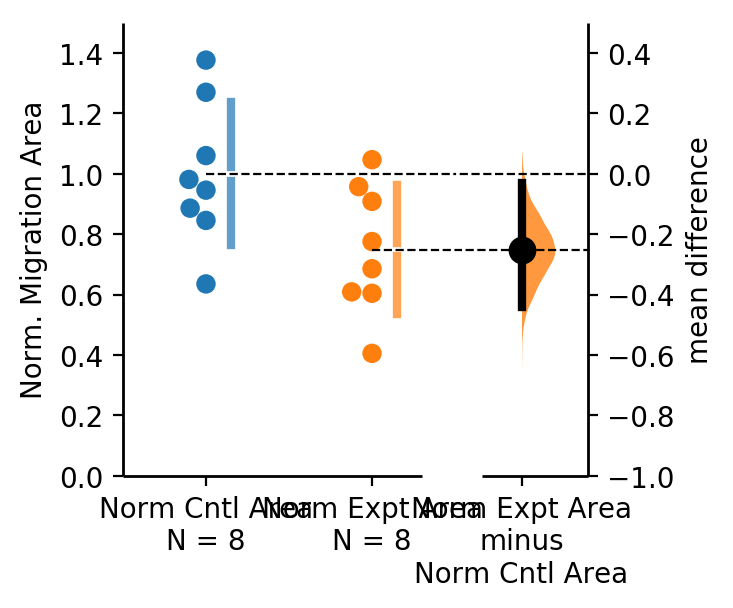

In [185]:
fig1 = results.mean_diff.plot(
    #Set overall figure parameters
                dpi=200
                ,fig_size=(3,3)
    
    #Edit legend features, use matplotlib.Axes.legend kwargs in dictionary format
#                 ,legend_kwargs={'loc':'upper left'
#                                 ,'frameon':True}

    
    #Edit 0 line features, use matplotlib.Axes.hlines kwargs in dictionary format
                ,reflines_kwargs= {'linestyle':'dashed'      
                               ,'linewidth':.8
                               ,'color' : 'black'}
    
    #Set swarm plot parameters    
                ,swarm_label='Norm. Migration Area'
                ,swarm_ylim=(0,1.5)
                ,show_pairs=False                    #connect paired points? Yes (True), no (False)
#                 ,color_col='Image'                   #color points based on defined column identifier
                ,swarm_desat=1
                ,group_summaries='mean_sd'           #display mean+/-sd as bars next to swarm plots
                ,group_summaries_offset=0.15
    #Edit swarmplot features, use seaborn.swarmplot kwargs in dictionary format
                ,swarmplot_kwargs={'size':7}

    
    #Edit group summary line features, use matplotlib.lines.Line2D kwargs in dictionary format
                ,group_summary_kwargs={'lw':3
                                      ,'alpha':.7}
    #Set effect size plot parameters
                ,float_contrast=True                 #displays mean difference next to graph (True) or below graph (False)
                ,contrast_label='mean difference'
                ,es_marker_size=9 
                ,halfviolin_desat=1
                ,halfviolin_alpha=0.8
    #Edit violin features, use sns.violinplot kwargs in dictionary format
                ,violinplot_kwargs={'widths':0.5}
    
    #Edit legend features, use matplotlib.Axes.legend kwargs in dictionary format
#                 ,legend_kwargs={'loc':'upper left'
#                                 ,'frameon':True}


    #Edit slopegraph features, use 
                    #kwargs in dictionary format
#                 ,slopegraph_kwargs={'color':'blue'}
                             )

In [164]:
plt.Axes?

Init signature: plt.Axes(fig, rect, facecolor=None, frameon=True, sharex=None, sharey=None, label='', xscale=None, yscale=None, **kwargs)
Docstring:     
The :class:`Axes` contains most of the figure elements:
:class:`~matplotlib.axis.Axis`, :class:`~matplotlib.axis.Tick`,
:class:`~matplotlib.lines.Line2D`, :class:`~matplotlib.text.Text`,
:class:`~matplotlib.patches.Polygon`, etc., and sets the
coordinate system.

The :class:`Axes` instance supports callbacks through a callbacks
attribute which is a :class:`~matplotlib.cbook.CallbackRegistry`
instance.  The events you can connect to are 'xlim_changed' and
'ylim_changed' and the callback will be called with func(*ax*)
where *ax* is the :class:`Axes` instance.
Init docstring:
Build an axes in a figure.

Parameters
----------
fig : `~matplotlib.figure.Figure`
    The axes is build in the `.Figure` *fig*.

rect : [left, bottom, width, height]
    The axes is build in the rectangle *rect*. *rect* is in
    `.Figure` coordinates.

sharex, sh

In [ ]:
fig1, stat